In [1]:
import json

In [2]:
# path = "../data/bbox/bbox_2.json"
path = "../notebooks/bounding_boxes.geojson"
with open(path) as file:
    data = json.load(file)

In [3]:
coords = data['features'][16300]['geometry']['coordinates'][0]

In [4]:
# coords = data['geometry']['coordinates'][0]

In [5]:
bl = (min(row[0] for row in coords), min(row[1] for row in coords))

In [6]:
tr = (max(row[0] for row in coords), max(row[1] for row in coords))

In [7]:
bl, tr

((127.5276372013665, -12.668655523943897),
 (127.57361571624578, -12.622677009064622))

In [8]:
from sentinelhub import SentinelHubRequest, SentinelHubDownloadClient, BBox, CRS, DataCollection, MimeType, SHConfig
from sentinelhub import WmsRequest, WcsRequest
from sentinelhub import constants, CustomUrlParam
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt

In [9]:
load_dotenv()

True

In [10]:
config = SHConfig()
config.sh_client_id = os.getenv("CLIENT_ID")
config.sh_client_secret = os.getenv("CLIENT_SECRET")

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def plot_image(image, factor, clip_range, **kwargs):
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
bbox = BBox((bl, tr), crs=CRS.WGS84)
size = (512, 512)
time_interval = "2023-08-30", "2023-08-31"
data_folder = "../sat_imgs"

evalscript_true_color ="""//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B09", "B11", "B12", "CLM"],
        }],
        output: {
            bands: 11
        }
    };
}

function bilinearInterpolation(value, fromResolution, toResolution) {
    // Perform bilinear interpolation manually
    return value * (fromResolution / toResolution);
}

function evaluatePixel(sample) {
    return [
        bilinearInterpolation(sample.B02, 10, 10),
        bilinearInterpolation(sample.B03, 10, 10),
        bilinearInterpolation(sample.B04, 10, 10),
        bilinearInterpolation(sample.B05, 20, 10),
        bilinearInterpolation(sample.B06, 20, 10),
        bilinearInterpolation(sample.B07, 20, 10),
        bilinearInterpolation(sample.B8A, 20, 10),
        bilinearInterpolation(sample.B09, 20, 10),
        bilinearInterpolation(sample.B11, 20, 10),
        bilinearInterpolation(sample.B12, 20, 10),
        sample.CLM,
    ];
}"""
# evalscript_true_color = """
# //VERSION=3

# function setup() {
#     return {
#         input: [{
#             bands: ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B09", "B11", "B12"],
#         }],
#         output: {
#             bands: 10
#         }
#     };
# }

# function evaluatePixel(sample) {
#     return [sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B8A, sample.B09, sample.B11, sample.B12];
# }
# """

request = SentinelHubRequest(
    data_folder = data_folder,
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            mosaicking_order="leastCC",
#             other_args={'processing': {'upsampling': 'BICUBIC'}}
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

image = request.get_data()[0]
# print(np.sum(image))
# image = request.get_data(save_data = True, show_progress=True)

In [13]:
clm = image[..., -1]

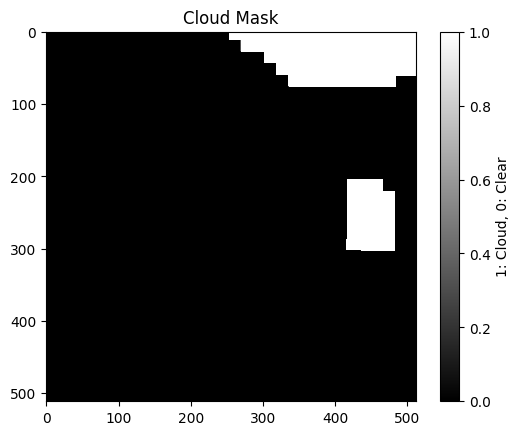

In [16]:
plt.imshow(clm, cmap='gray', vmin=0, vmax=1)
plt.colorbar(label='1: Cloud, 0: Clear')
plt.title('Cloud Mask')
plt.show()

In [119]:
im = image[..., 0 : 3]

In [120]:
im.max()

194

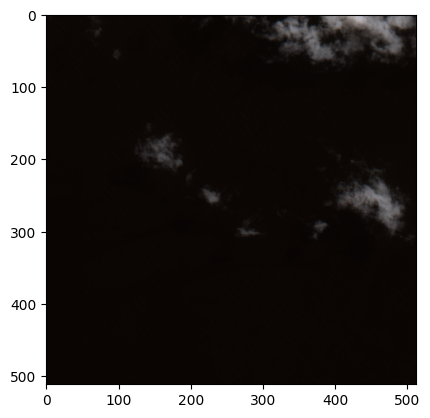

In [121]:
plt.imshow(im)

In [65]:
import rasterio
raster =  rasterio.open('../sat_imgs/7139024cb32c50c31d02314beb8e143d/response.tiff')
gt = raster.transform
len(gt)

9

In [23]:
image[..., 0]

array([[6, 6, 7, ..., 7, 7, 7],
       [6, 6, 6, ..., 6, 6, 7],
       [6, 6, 7, ..., 7, 7, 7],
       ...,
       [6, 7, 7, ..., 7, 7, 7],
       [6, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], dtype=uint8)

In [79]:
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling

In [92]:
with rasterio.open('../sat_imgs/f30c265cc1145e41034a916452f89a2b/response.tiff') as src:
    print(src.count)

10


In [88]:
data = np.load('../sat_imgs/1/L2A.npy')


In [90]:
dst_crs = 'EPSG:4326'

# Extract information from the NumPy array
bands, height, width = data.shape

# Set the desired resolution (e.g., 10m)
new_resolution = 10.0

# Calculate new width and height based on the new resolution
new_width = int(width * 20 / new_resolution)
new_height = int(height * 20 / new_resolution)

# Set the new transform with the desired resolution
new_transform = from_origin(0, 0, new_resolution, new_resolution)

# Create a new array for the upsampled data
upsampled_data = np.zeros((new_height, new_width, bands), dtype=data.dtype)

# Iterate over bands and perform resampling
for band in range(3, 10):
    reproject(
        source=data[:, :, band],
        destination=upsampled_data[:, :, band],
        src_transform=None,  # Use None if no transform is provided in the input data
        src_crs = dst_crs,
        dst_transform=new_transform,
        dst_crs = dst_crs,
        resampling=Resampling.bilinear,
        src_method=Resampling.no_transform
    )

AttributeError: no_transform

In [16]:
bbox = BBox((bl, tr), crs=CRS.WGS84)
size = (512, 512)
time_interval = "2023-08-30", "2023-08-31"
data_folder = "../sat_imgs"

evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["DEM"]
        }],
        output: {
            bands: 1,
            sampleType: "FLOAT32" 
        }
    };
}

function evaluatePixel(sample) {
    return [sample.DEM];
}
"""

request = SentinelHubRequest(
    data_folder = data_folder,
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=time_interval,
            mosaicking_order="leastCC"
            
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

dem = request.get_data()[0]
# print(np.sum(image))
# image = request.get_data(save_data = True, show_progress=True)

In [13]:
from scipy.ndimage import median_filter

In [14]:
%run ../slope.py

In [17]:
def process_dem(dem):
    dem =  median_filter(dem, size = 5)
    dem = calcSlope(dem.reshape((1, 512, 512)),
                      np.full((512, 512), 10),
                      np.full((512, 512), 10), 
                      zScale = 1, minSlope = 0.02)
    dem = dem / 90
    dem = dem.reshape((512, 512, 1))
    dem = dem[1:-1, 1:-1]
    dem = median_filter(dem, 5)[2:-2, 2:-2]
    return dem


In [18]:
dem = process_dem(dem)

In [50]:
path = os.path.join("../sat_imgs", "1")

In [51]:
os.mkdir(path)

In [52]:
np.save(path + "/dem", dem)

In [47]:
for folder, _, filenames in os.walk(request.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

../sat_imgs/0a63ba069684fa673af9ea69e0cf5d8b/request.json
../sat_imgs/0a63ba069684fa673af9ea69e0cf5d8b/response.tiff
../sat_imgs/5515fc22c452136d8490bdd7c357a570/request.json
../sat_imgs/5515fc22c452136d8490bdd7c357a570/response.png
../sat_imgs/0b72b652985b4785df4400ef164c6874/request.json
../sat_imgs/0b72b652985b4785df4400ef164c6874/response.tiff


In [91]:
from datetime import datetime, timedelta

In [76]:
today = datetime.today()
formatted_date = today.strftime("%Y-%m-%d")
formatted_date

'2023-12-03'

In [77]:
inputdate = "2023-09-13"


In [88]:
dt = [int(d) for d in inputdate.split('-')]
dtt = datetime(*dt)

In [92]:
st = dtt - timedelta(days = 60)
end = dtt + timedelta(days = 60)
print(st.strftime("%Y-%m-%d"))
print(end.strftime("%Y-%m-%d"))

2023-07-15
2023-11-12


In [90]:
dem_request = WcsRequest(
                         layer='DEM', bbox=bbox,
                         resx = "10m", resy = "10m",
                         config=config,
                         image_format= MimeType.TIFF,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
dem_image_init = dem_request.get_data()[0]

TypeError: __init__() missing 1 required keyword-only argument: 'data_collection'

In [53]:
from slope import calcSlope

In [55]:
os.path.isdir(path) 

True

In [56]:
request.execute()

AttributeError: 'SentinelHubRequest' object has no attribute 'execute'